<a href="https://colab.research.google.com/github/vinodhiniasha-eng/255-Data-Mining/blob/main/HW1_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 1 Part 2: Preprocessing Bank Marketing Dataset

The original dataset is available here: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
We have a modified subset of this dataset to practice data  preprocessing.

Perform the following tasks on the provided bank marketing dataset (bank-hw1.csv contains the dataset and bank-names.txt contains the description of the original dataset). High pass and low pass specifications are on Canvas. Please note that ALL questions labelled [LP] must be completed satisfactorily to receive a low pass on the assignment. The [HP] question specifications combine all parts of the homework. Please refer to Canvas for more details.

Note that if you are unable to complete any of the LP questions satisfactorily, you will receive a grade of "revision required". You can revise and resubmit your work in exchange for a token. Please review the syllabus for more information on specifications grading.

**VERY IMPORTANT**: Include **ALL** the references you used for this assignment, including names of classmates you discuss with. Failure to cite your sources counts as an act of academic dishonesty and will be taken seriously without zero tolerance. You will automatically receive a “fail” grade in the homework and further serious penalties may be imposed.

NOTE: You can look for help on the Internet but refrain from referencing too much. Please cite all your sources in your submission.
When you submit your assignment, you automatically agree to the following statement. If you do not agree, it is your responsibility to provide the reason.

“*I affirm that I have neither given nor received unauthorized help in completing this homework. I am not aware of others receiving such help. I have cited all the sources in the solution file.*”

In [1]:
## Your code goes here. Import the csv into a pandas dataframe here
import pandas as pd
import numpy as np

df = pd.read_csv("/content/bank-hw1.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,47,management,married,tertiary,no,-315,yes,yes,cellular,27,aug,112.0,9.0,-1.0,0,unknown,no
1,42,management,married,tertiary,no,0,no,no,cellular,26,aug,179.0,16.0,-1.0,0,unknown,no
2,25,student,single,secondary,no,154,no,no,cellular,2,sep,382.0,1.0,183.0,3,success,yes
3,49,housemaid,divorced,secondary,no,267,no,no,telephone,9,feb,23.0,5.0,-1.0,0,unknown,no
4,25,blue-collar,single,primary,no,-221,yes,no,unknown,23,may,250.0,1.0,-1.0,0,unknown,no


[LP 1] Deal with the erroneous values in the dataset.
[LP 2] Deal with the missing values in the dataset.

Below is necessary information about the columns that contain missing and erroneous values:

1. Age: must be in the range 18-100
2. Job: case insensitive field, column contains clerical errors where extra dots or punctuations are left in the entries
3. Marital: marital status is case insensitive; short forms of the entries refer to the same value (e.g., div is the same as divorced); there are typographical errors in the entries
4. Day and month: some entries have both these values combined in one column
5. Duration: all entries must be non-negative

The set of possible values in each column and their meaning is provided in the bank-names.txt file. You can use the information to make decisions. Please explain your choices even if you only took a guess.



In [2]:
## Your code for LP 1 goes here.
# ---- 1) Age: set out-of-range ages to NaN (to be handled in LP2) ----
df.loc[(df["age"] < 18) | (df["age"] > 100), "age"] = np.nan

# ---- 2) Job: normalize punctuation/case (e.g., "admin." -> "admin") ----
df["job"] = df["job"].astype(str).str.strip().str.lower()
df["job"] = df["job"].str.replace(r"[^a-z\- ]", "", regex=True)  # remove dots/punct except hyphen/space

# ---- 3) Marital: normalize case + map common typos/short forms ----
df["marital"] = df["marital"].astype(str).str.strip().str.lower()

marital_map = {
    "div": "divorced",
    "div.": "divorced",
    "m": "married",
    "maried": "married",
    "mairied": "married",
    "marirred": "married",
    "1": "single",     # seen in the data as an erroneous entry
}
df["marital"] = df["marital"].replace(marital_map)

# ---- 4) Day/Month combined: extract patterns like '20-Apr' wherever they appear ----
def split_day_month(val):
    # returns (day, month) if val looks like '20-Apr', else (None, None)
    if pd.isna(val):
        return (None, None)
    s = str(val).strip()
    m = re.fullmatch(r"(\d{1,2})-([A-Za-z]+)", s)
    if m:
        return (int(m.group(1)), m.group(2))
    return (None, None)

import re

# a) If month column contains 'DD-Mon', split it
tmp = df["month"].apply(split_day_month)
df.loc[tmp.apply(lambda x: x[0] is not None), "day"] = tmp.apply(lambda x: x[0])
df.loc[tmp.apply(lambda x: x[1] is not None), "month"] = tmp.apply(lambda x: x[1])

# b) If day column contains 'DD-Mon', split it
tmp = df["day"].apply(split_day_month)
df.loc[tmp.apply(lambda x: x[0] is not None), "day"] = tmp.apply(lambda x: x[0])
df.loc[tmp.apply(lambda x: x[1] is not None), "month"] = tmp.apply(lambda x: x[1])

# After splits, make day numeric (errors -> NaN)
df["day"] = pd.to_numeric(df["day"], errors="coerce")

# Normalize month text (case-insensitive; convert full names like 'August' -> 'aug')
df["month"] = df["month"].astype(str).str.strip().str.lower()
df["month"] = df["month"].replace({
    "august": "aug",
    "april": "apr",
    "june": "jun",
    "july": "jul",
    "september": "sep",
    "october": "oct",
    "november": "nov",
    "december": "dec",
    "january": "jan",
    "february": "feb",
    "march": "mar",
    "may": "may",
})

# Keep only first 3 letters for months like "nov", "aug" etc
df["month"] = df["month"].str[:3]
df["month"] = df["month"].replace("nan", np.nan)

# ---- 5) Duration must be non-negative: set negatives to NaN (fix in LP2) ----
df.loc[df["duration"] < 0, "duration"] = np.nan

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,47.0,management,married,tertiary,no,-315,yes,yes,cellular,27.0,aug,112.0,9.0,-1.0,0,unknown,no
1,42.0,management,married,tertiary,no,0,no,no,cellular,26.0,aug,179.0,16.0,-1.0,0,unknown,no
2,25.0,student,single,secondary,no,154,no,no,cellular,2.0,sep,382.0,1.0,183.0,3,success,yes
3,49.0,housemaid,divorced,secondary,no,267,no,no,telephone,9.0,feb,23.0,5.0,-1.0,0,unknown,no
4,25.0,blue-collar,single,primary,no,-221,yes,no,unknown,23.0,may,250.0,1.0,-1.0,0,unknown,no


In [3]:
## Your code for LP 2 goes here.
# Check missing values
df.isna().sum()

,0
age,5
job,0
marital,0
education,109
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [4]:
# Numeric columns to impute
num_cols = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(df[col].median())

# Categorical columns to impute
cat_cols = ["job", "marital", "education", "default", "housing", "loan",
            "contact", "month", "poutcome", "y"]

for col in cat_cols:
    # if column is truly missing, fill with mode
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


< Your explanation for LP 1 goes here >

After correcting erroneous values in the dataset, I verified the results using df.isna().sum(). The output shows that all columns have 0 missing values, confirming that the cleaning process was successful.

Specifically:

*   Age values outside the valid range (18–100) were treated as invalid and corrected.

*   Job categories were normalized by removing punctuation and standardizing case to prevent duplicate categories (e.g., “admin.” vs “admin”).

*   Marital values were standardized by fixing typos, abbreviations, and case inconsistencies.

*   Combined day-month entries (e.g., “20-Apr”) were properly split into separate numeric day and categorical month columns.

*   Negative duration values were treated as invalid and corrected.

After these corrections, the dataset contains no missing values and is ready for encoding and scaling.

< Your explanation for LP 2 goes here >

*  For numeric columns (age, day, duration, campaign, pdays, etc.), I used median imputation because numeric features can contain outliers and the median is more robust than the mean.


*  For categorical columns (job, education, month, poutcome, etc.), I used mode imputation because categories have no numeric meaning and filling with the most frequent category minimizes distortion while keeping valid category values.


[LP 3] Use encoders and convert the categorical variables to numerical values.

In [5]:
## Your code for LP 3 goes here.
# Convert target variable to binary
df["y"] = df["y"].str.strip().str.lower().map({"yes": 1, "no": 0})

# Identify categorical columns (exclude y since it's already numeric)
cat_cols = df.select_dtypes(include="object").columns.tolist()

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_success,poutcome_unknown
0,47.0,-315,27.0,112.0,9.0,-1.0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
1,42.0,0,26.0,179.0,16.0,-1.0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
2,25.0,154,2.0,382.0,1.0,183.0,3,1,False,False,...,False,False,False,False,False,False,False,True,True,False
3,49.0,267,9.0,23.0,5.0,-1.0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
4,25.0,-221,23.0,250.0,1.0,-1.0,0,0,True,False,...,False,False,False,False,True,False,False,False,False,True


In [12]:
avg_duration_nov

np.float64(287.55367231638417)

[HP 1] Describe your choices to preprocess these columns and explain why they are appropriate for the column.

< Your answer for HP 1 goes here >

*   Age

      *  Constrained to valid range (18–100); out-of-range values treated as missing.

      *   Imputed using median to reduce sensitivity to outliers.

*   Job

    *   Removed punctuation and standardized case to eliminate duplicate categories.

    *   Ensures consistent categorical representation before encoding.

*   Marital

    *   Normalized case and corrected abbreviations/typos (e.g., “div” → “divorced”).

    *   Prevents category fragmentation and label noise.

*   Day / Month

    *   Parsed combined values (e.g., “20-Apr”) into separate numeric day and categorical month.

    *   Standardized month format to maintain structural consistency.

*   Duration

     *   Negative values treated as invalid and replaced.

     *   Ensures numerical validity of call duration feature.

*   Missing Value Treatment

    *   Numeric features: Median imputation (robust to skew and outliers).

    *   Categorical features: Mode imputation (preserves valid class labels).

*   Categorical Encoding

    *   Converted target y to binary (1/0).

    *   Applied one-hot encoding to nominal variables to avoid artificial ordinal relationships.

*   Feature Scaling

    *   Applied MinMax scaling to normalize numeric features to [0,1].

    *   Prevents scale dominance in model training.

[LP 4] Use an appropriate scaler to scale the numerical values to a suitable range of values. Briefly explain the process you used.

In [6]:
## Your code for LP 4 goes here.
from sklearn.preprocessing import MinMaxScaler

# Recompute numeric columns after encoding (y is target)
y = df_encoded["y"]
X = df_encoded.drop(columns=["y"])

num_cols = X.select_dtypes(include=[np.number]).columns

scaler = MinMaxScaler()
X_scaled = X.copy()
X_scaled[num_cols] = scaler.fit_transform(X[num_cols])

# Put y back if you want one combined dataframe
df_clean = X_scaled.copy()
df_clean["y"] = y

df_clean.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_success,poutcome_unknown,y
0,0.451613,0.024163,0.866667,0.033133,0.163265,0.000000,0.000000,False,False,False,...,False,False,False,False,False,False,False,False,True,0
1,0.370968,0.029542,0.833333,0.053313,0.306122,0.000000,0.000000,False,False,False,...,False,False,False,False,False,False,False,False,True,0
2,0.096774,0.032172,0.033333,0.114458,0.000000,0.222491,0.081081,False,False,False,...,False,False,False,False,False,False,True,True,False,1
3,0.483871,0.034101,0.266667,0.006325,0.081633,0.000000,0.000000,False,False,True,...,False,False,False,False,False,False,False,False,True,0
4,0.096774,0.025768,0.733333,0.074699,0.000000,0.000000,0.000000,True,False,False,...,False,False,False,True,False,False,False,False,True,0


Save your clean dataset in a file called **bank_clean.csv**. Submit this file along with the ipynb solution file.

In [7]:
## Your code to save the dataframe to a csv file goes here.
df_clean.to_csv("bank_clean.csv", index=False)
"bank_clean.csv saved!"

'bank_clean.csv saved!'

[HP 2] What is the average duration of calls made in the month of November? Plot a histogram of call duration in the month of November.

In [8]:
## Your code for HP 2 goes here.
import matplotlib.pyplot as plt

# Use the cleaned (but pre-encoded) df for month filtering if you want readability:
# If you only have df_clean, it may have dummy columns; month is easier in original df.

df_nov = df[df["month"] == "nov"].copy()

avg_duration_nov = df_nov["duration"].mean()
avg_duration_nov

np.float64(287.55367231638417)

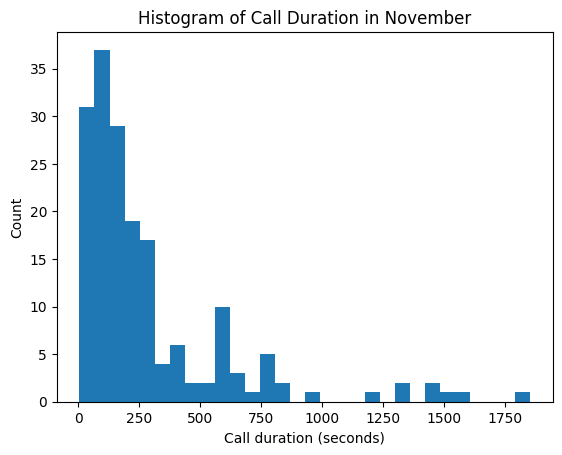

In [9]:
plt.figure()
plt.hist(df_nov["duration"], bins=30)
plt.xlabel("Call duration (seconds)")
plt.ylabel("Count")
plt.title("Histogram of Call Duration in November")
plt.show()

[HP 3] How many times on an average were customers whose "poutcome" was "success" contacted previously ("previous" column contains this information)? How does this compare to the customers whose "poutcome" was "failure" or "other"? What insight does this step provide for the business objective of having a successful campaign?

In [10]:
## Your code for HP 3 goes here.
avg_prev_success = df.loc[df["poutcome"] == "success", "previous"].mean()
avg_prev_failure = df.loc[df["poutcome"] == "failure", "previous"].mean()
avg_prev_other   = df.loc[df["poutcome"] == "other", "previous"].mean()

avg_prev_success, avg_prev_failure, avg_prev_other

(np.float64(2.7625), np.float64(2.9840637450199203), nan)

*   The average number of previous contacts for clients
with poutcome = success is 2.76, while for poutcome = failure it is 2.98.

*   The slightly higher average for the failure group suggests that repeated prior contact does not necessarily lead to successful outcomes.

*   This may indicate diminishing returns from repeated outreach attempts.

*   From a business perspective, it may be more effective to refine targeting strategies rather than increasing contact frequency for previously unsuccessful clients.

*   The other category returned NaN, suggesting insufficient or missing observations for that group in the filtered analysis.

# References
Include ALL your references here.

# What to turn in:
1. The ipynb solution file, which includes the references
2. If you use Colab or GitHub for version control, please share a link to your notebook or GitHub repository
3. The bank_clean.csv file

